In [358]:
from pymonntorch import Network, NeuronGroup, Recorder, EventRecorder, Behavior, SynapseGroup
from matplotlib import pyplot as plt
import torch, math, random, time, sympy, os, sys
import numpy as np

""" Set the random seed for reproducibility """;
# torch.manual_seed(0);

In [359]:
class TimeResolution(Behavior):
    def initialize(self, network : Network) -> None:
        network.dt = self.parameter("dt", default = 0.1)

In [550]:
class Current(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        """ Initialize the current """
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        
        neuron_G.I = neuron_G.vector(mode = self.init_current)
        neuron_G.I_cpy = neuron_G.vector(mode = self.init_current)

    def forward(self, neuron_G : NeuronGroup) -> None:
        """ Update the current according to the given function F """
        def eval_F() -> NeuronGroup.vector:
            """ Not tested. Not used. """
            return sympy.lambdify(sympy.symbols(list(self.vars.keys())), self.F)(*list(self.vars.values()))
        
        """ Different options for the current function F """
        if   self.F == "constant"   :
            neuron_G.I.fill_(self.init_current)
            neuron_G.I_cpy.fill_(self.init_current)
        elif self.F == "sin"        : neuron_G.I.fill_(self.init_current + self.amplitude * math.sin(2 * math.pi * self.frequency * neuron_G.network.iteration * neuron_G.network.dt + self.phase))
        elif self.F == "noise"      :
            neuron_G.I_cpy += random.gauss(self.mean, self.std)
            neuron_G.I_cpy[neuron_G.I_cpy < 0] = 0
            neuron_G.I.copy_(neuron_G.I_cpy)
        elif self.F == "train_pulse": neuron_G.I.fill_(self.init_current + self.amplitude) if neuron_G.network.iteration * neuron_G.network.dt % self.period == 0 else neuron_G.I.fill_(self.init_current)
        elif self.F == "step"       :
            neuron_G.I.fill_(self.init_current + self.amplitude) if self.t0 < neuron_G.network.iteration * neuron_G.network.dt < self.t1 else neuron_G.I.fill_(self.init_current)
            neuron_G.I_cpy.copy_(neuron_G.I)
        elif self.F == "noisy_step":
            noise = random.gauss(self.mean, self.std)
            neuron_G.I.fill_(self.init_current + self.amplitude + noise) if self.t0 < neuron_G.network.iteration * neuron_G.network.dt < self.t1 else neuron_G.I.fill_(self.init_current + noise)
            neuron_G.I_cpy.copy_(neuron_G.I)

In [551]:
class LIF(Behavior):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        """ Initialize the LIF neuron. This is the rationale for different variants of LIF models. """
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        
        neuron_G.SPIKECNT = neuron_G.vector(mode = 0)
        neuron_G.THRESHOLD = neuron_G.vector(mode = self.threshold)
        neuron_G.U = neuron_G.vector(mode = self.u_init)
        neuron_G.REFRACTORY = neuron_G.vector(mode = 0)
        neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
        neuron_G.A = neuron_G.vector(mode = 0)
        
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()
        neuron_G.U[neuron_G.SPIKE] = self.u_reset
        neuron_G.REFRACTORY[neuron_G.SPIKE] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size

    def forward(self, neuron_G : NeuronGroup) -> None:
        """ Update the membrane potential U of the LIF neuron. """
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        """ Simulate the refractoriness according to the given parameter refractoryMODE """
        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += leakage / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.U += (leakage) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a * neuron_G.network.dt
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        else:
            neuron_G.U += (leakage + currents) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= neuron_G.THRESHOLD
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        neuron_G.REFRACTORY[neuron_G.SPIKE.logical_or(neuron_G.REFRACTORY > 0)] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size

class ELIF(LIF):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        super().initialize(neuron_G)

    def forward(self, neuron_G : NeuronGroup) -> None:
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += currents / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a * neuron_G.network.dt
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        else:
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.u_rest) / self.deltaT)) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        neuron_G.REFRACTORY[neuron_G.SPIKE.logical_or(neuron_G.REFRACTORY > 0)] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size


class AELIF(ELIF):
    def initialize(self, neuron_G : NeuronGroup) -> None:
        super().initialize(neuron_G)
        neuron_G.W = neuron_G.vector(mode = 0)

    def forward(self, neuron_G : NeuronGroup) -> None:
        leakage = -(neuron_G.U - self.u_rest)
        currents = self.R * neuron_G.I

        neuron_G.W += (self.a * (neuron_G.U - self.u_rest) - neuron_G.W + self.b * self.tau_w * neuron_G.SPIKE.float()) / self.tau_w * neuron_G.network.dt
        if self.refractoryON and self.refractoryMODE == "BLOCK_CURRENT":
            neuron_G.U += (leakage + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.U[neuron_G.REFRACTORY == 0] += (currents) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        elif self.refractoryON and self.refractoryMODE == "ADAPTIVE_THRESHOLD":
            neuron_G.THRESHOLD += (-(neuron_G.THRESHOLD - self.theta0) + self.theta * neuron_G.SPIKE.float()) / self.tau_a
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset
        
        else:
            neuron_G.U += (leakage + currents + self.deltaT * torch.exp((neuron_G.U - self.theta_rh) / self.deltaT) - neuron_G.W * self.R) / self.tau * neuron_G.network.dt
            neuron_G.SPIKE = neuron_G.U >= self.threshold
            neuron_G.U[neuron_G.SPIKE] = self.u_reset

        neuron_G.REFRACTORY[neuron_G.SPIKE or neuron_G.REFRACTORY > 0] += neuron_G.network.dt
        neuron_G.REFRACTORY[neuron_G.REFRACTORY > self.refractory_T] = 0
        neuron_G.SPIKECNT += neuron_G.SPIKE.float()
        neuron_G.A = torch.sum(neuron_G.SPIKE.float()) / neuron_G.size


In [552]:
class Dendrite(Behavior):
    def forward(self, neuron_G : NeuronGroup) -> None:
        for synapse in neuron_G.afferent_synapses["All"]:
            neuron_G.I += synapse.I
        # for synapse in neuron_G.afferent_synapses["Inhibitory"]:
        #     neuron_G.I -= synapse.I
        #     neuron_G.I[neuron_G.I < 0] = 0

In [553]:
class Transfer(Behavior):
    def initialize(self, synapse_G : SynapseGroup) -> None:
        self.params = self.parameter("params", default = {})
        for k, v in self.params.items():
            setattr(self, k, v)
        self.postSIZE = synapse_G.dst.size
        self.preSIZE  = synapse_G.src.size

        if self.transfer_mode == "Conductivity":
            synapse_G.G_syn = torch.zeros(self.preSIZE, self.postSIZE)    

        if self.connectivity_mode == "FULL":
            """ Full connectivity """
            self.w = self.J0/self.preSIZE
            self.W = synapse_G.matrix(mode = self.w)
        elif self.connectivity_mode == "FCP":
            """ Random connectivity: fixed coupling probability """
            self.w = self.J0/(self.p * self.preSIZE)
            self.W = torch.rand(self.preSIZE, self.postSIZE) < self.p
            self.W = self.W.float() * self.w
        elif self.connectivity_mode == "FPP":
            """ Random connectivity: fixed number of presynaptic partners """
            self.w = self.J0/self.N
            self.W = torch.zeros(self.preSIZE, self.postSIZE)
            for i in range(self.postSIZE):
                indices = torch.randperm(self.preSIZE)[:self.N]
                self.W[indices, i] = self.w


    def forward(self, synapse_G : SynapseGroup) -> None:
        if self.transfer_mode == "Dirac":    
            preSPIKE = synapse_G.src.SPIKE
            synapse_G.I = torch.sum(self.W[preSPIKE], axis = 0) * ((-1)**self.isInhibitory)
        # elif self.transfer_mode == "Conductivity":
        #     preSPIKE = synapse_G.src.SPIKE  
        #     synapse_G.G_syn += (self.g * preSPIKE.float() - synapse_G.G_syn / self.tau_syn) * synapse_G.network.dt
        #     synapse_G.I = torch.sum(self.W * synapse_G.G_syn, axis = 0)

In [554]:
lif_params = {
    "u_rest" : -80,
    "u_reset" : -90,
    "u_init" : "normal(-80, 10)",
    "tau" : 10,
    "R" : 1,
    "threshold" : "normal(-55, 10)",
    "refractoryON" : False,
    "refractoryMODE" : "ADAPTIVE_THRESHOLD",
    "theta0" : -30,
    "theta" : 10,
    "tau_a" : 200,
    "refractory_T" : 1
}; lif = LIF(params = lif_params)

In [555]:
def A():
    """ Questions 1, 2 and 3 can be answered in this section. """
    ITERATIONS = 1000
    I1_constant_params = { 
        "F" : "constant",
        "init_current" : 40,
    }; I1_constant = Current(params = I1_constant_params)

    I1_noise_params = {
        "F" : "noise",
        "init_current" : 40,
        "mean" : 0,
        "std" : 0.2,
    }; I1_noise = Current(params = I1_noise_params)

    I1 = I1_noise

    population1_behavior = {
        2 : I1,
        4 : Dendrite(),
        5 : lif,
        9 : Recorder(tag = "population1_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "population1_event", variables = ["SPIKE"])
    }

    I2_constant_params = { 
        "F" : "constant",
        "init_current" : 40,
    }; I2_constant = Current(params = I2_constant_params)

    I2_noise_params = {
        "F" : "noise",
        "init_current" : 40,
        "mean" : 0,
        "std" : 0.2,
    }; I2_noise = Current(params = I2_noise_params)

    I2 = I2_noise

    population2_behavior = {
        2 : I2,
        4 : Dendrite(),
        5 : lif,
        9 : Recorder(tag = "population2_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "population2_event", variables = ["SPIKE"])
    }

    network = Network(behavior={1: TimeResolution(dt = 0.1)}, dtype=torch.float64, device = "cpu", synapse_mode = "SxD")

    Excitatory_population = NeuronGroup(size = 800, net = network, tag = "Excitatory", behavior = population1_behavior)
    Inhibitory_population = NeuronGroup(size = 200, net = network, tag = "Inhibitory", behavior = population2_behavior)

    synapseGroup1_prams = {
        "transfer_mode" : "Dirac",
        "connectivity_mode" : "FPP",
        "N" : 150,
        "p" : 0.9,
        "tau_syn" : 5,
        "g" : 20,
        "E_syn" : 0,
        "J0" : 1000,
        "isInhibitory" : 0
    }
    synapseGroup2_prams = {
        "transfer_mode" : "Dirac",
        "connectivity_mode" : "FPP",
        "N" : 150,
        "p" : 0.9,
        "tau_syn" : 5,
        "g" : 20,
        "E_syn" : -90,
        "J0" : 1500,
        "isInhibitory" : 1
    }
    synapse_G_EI = SynapseGroup(net = network, src = Excitatory_population, dst = Inhibitory_population, behavior = {3 : Transfer(params = synapseGroup1_prams), 5 : Recorder(tag = "EI_record", variables = ["I"])}, tag = "Excitatory")
    synapse_G_IE = SynapseGroup(net = network, src = Inhibitory_population, dst = Excitatory_population, behavior = {3 : Transfer(params = synapseGroup2_prams), 5 : Recorder(tag = "IE_record", variables = ["I"])}, tag = "Inhibitory")

    network.initialize()
    network.simulate_iterations(iterations = ITERATIONS)
    
    fig, axs = plt.subplots(3,1)
    fig.set_size_inches(10, 15)

    axs[0].set_title("Raster plot")
    axs[0].scatter(network["population1_event", 0].variables["SPIKE"][:, 0], network["population1_event", 0].variables["SPIKE"][:, 1], s = 1, c = "b")
    axs[0].scatter(network["population2_event", 0].variables["SPIKE"][:, 0], network["population2_event", 0].variables["SPIKE"][:, 1] + Excitatory_population.size, s = 1, c = "r")
    axs[0].legend(["Excitatory", "Inhibitory"])
    
    act = network["population1_record", 0].variables["A"]
    act = np.convolve(act, np.ones(10)/10, mode = "same")
    axs[1].set_title("Populations activity")
    axs[1].plot(act, c = "b")
    act = network["population2_record", 0].variables["A"]
    act = np.convolve(act, np.ones(10)/10, mode = "same")
    axs[1].plot(act, c = "orange")
    axs[1].legend(["Excitatory", "Inhibitory"])

    

    axs[2].set_title("Input current")
    axs[2].plot(network["population1_record", 0].variables["I_cpy"][:, :1], c = "b")
    axs[2].plot(network["population2_record", 0].variables["I_cpy"][:, :1], c = "r")
    axs[2].legend(["Excitatory", "Inhibitory"])
    plt.show()


    # fig, axs = plt.subplots(1, 2)
    # fig.set_size_inches(10, 5)

    # fig.suptitle("Population 1")
    # axs[0].plot(network["population1_record", 0].variables["U"][:, :])
    # axs[1].plot(network["population1_record", 0].variables["I"][:, :])
    # # axs[2].plot(network["population1_record", 0].variables["A"])
    # plt.show()

    # fig, axs = plt.subplots(1, 2)
    # fig.set_size_inches(10, 5)

    # fig.suptitle("Population 2")
    # axs[0].plot(network["population2_record", 0].variables["U"][:, :])
    # axs[1].plot(network["population2_record", 0].variables["I"][:, :])
    # # axs[2].plot(network["population2_record", 0].variables["A"])
    # plt.show()

    # fig, axs = plt.subplots(1, 2)
    # axs[0].plot(network["EI_record", 0].variables["I"][:, :])
    # axs[1].plot(network["IE_record", 0].variables["I"][:, :])
    # axs[0].set_title("EI")
    # axs[1].set_title("IE")
    # plt.show()

    """ 
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    axs[0].plot(network["EI_record", 0].variables["I_cpy"][:, :])
    axs[1].plot(network["IE_record", 0].variables["I_cpy"][:, :])
    plt.show()
    """

In [556]:
def X():
    """ Questions 1, 2 and 3 can be answered in this section. """
    lif_params1 = {
        "u_rest" : -80,
        "u_reset" : -90,
        "u_init" : "normal(-80, 10)",
        "tau" : 10,
        "R" : 1,
        "threshold" : "normal(-55, 10)",
        "refractoryON" : False,
        "refractoryMODE" : "ADAPTIVE_THRESHOLD",
        "theta0" : -30,
        "theta" : 10,
        "tau_a" : 200,
        "refractory_T" : 1
    }; 
    ITERATIONS = 1000
    I1_constant_params = { 
        "F" : "constant",
        "init_current" : 40,
    }; I1_constant = Current(params = I1_constant_params)

    I1_noise_params = {
        "F" : "noise",
        "init_current" : 20,
        "mean" : 0,
        "std" : 0.2,
    }; I1_noise = Current(params = I1_noise_params)

    I1 = I1_noise

    lif = LIF(params = lif_params1)
    population1_behavior = {
        2 : I1,
        5 : lif,
        9 : Recorder(tag = "population1_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "population1_event", variables = ["SPIKE"])
    }

    I2_constant_params = { 
        "F" : "constant",
        "init_current" : 30,
    }; I2_constant = Current(params = I2_constant_params)

    I2_noise_params = {
        "F" : "noise",
        "init_current" : 20,
        "mean" : 0,
        "std" : 0.2,
    }; I2_noise = Current(params = I2_noise_params)
    I2 = I2_noise

    lif_params2 = {
        "u_rest" : -80,
        "u_reset" : -90,
        "u_init" : -80,
        "tau" : 10,
        "R" : 1,
        "threshold" : -55,
        "refractoryON" : False,
        "refractoryMODE" : "ADAPTIVE_THRESHOLD",
        "theta0" : -30,
        "theta" : 10,
        "tau_a" : 200,
        "refractory_T" : 1
    }; 
    lif2 = LIF(params = lif_params2)
    population2_behavior = {
        2 : I2,
        4 : Dendrite(),
        5 : lif2,
        9 : Recorder(tag = "population2_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "population2_event", variables = ["SPIKE"])
    }

    network = Network(behavior={1: TimeResolution(dt = 0.1)}, dtype=torch.float64, device = "cpu", synapse_mode = "SxD")

    Excitatory_population = NeuronGroup(size = 1, net = network, tag = "Excitatory", behavior = population1_behavior)
    Inhibitory_population = NeuronGroup(size = 1, net = network, tag = "Inhibitory", behavior = population2_behavior)

    synapseGroup1_prams = {
        "transfer_mode" : "Dirac",
        "connectivity_mode" : "FULL",
        "tau_syn" : 5,
        "g" : 20,
        "E_syn" : 0,
        "J0" : 5,
    }

    synapse_G_EI = SynapseGroup(net = network, src = Excitatory_population, dst = Inhibitory_population, behavior = {3 : Transfer(params = synapseGroup1_prams), 5 : Recorder(tag = "EI_record", variables = ["I"])}, tag = "Excitatory")

    network.initialize()
    network.simulate_iterations(iterations = ITERATIONS)


    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    fig.suptitle("Population 1")
    axs[0].plot(network["population1_record", 0].variables["U"][:, :])
    axs[1].plot(network["population1_record", 0].variables["I"][:, :])
    # axs[2].plot(network["population1_record", 0].variables["A"])
    plt.show()

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    fig.suptitle("Population 2")
    axs[0].plot(network["population2_record", 0].variables["U"][:, :])
    axs[1].plot(network["population2_record", 0].variables["I"][:, :])
    # axs[2].plot(network["population2_record", 0].variables["A"])
    plt.show()

    plt.plot(network["population1_record", 0].variables["I_cpy"][:, :])


Network['Network_1', 'Network'](Neurons: tensor(1500)|3 groups, Synapses: tensor(1500000)|6 groups){1:TimeResolution(dt=0.1,)}
NeuronGroup['Excitatory1', 'Excitatory', 'NeuronGroup', 'ng'](500){2:Current(params={'F': 'noisy_step', 'init_current': 30, 'mean': 0, 'std': 2, 't0': 25, 't1': 110, 'amplitude': 20},)4:Dendrite()5:LIF(params={'u_rest': -80, 'u_reset': -90, 'u_init': 'normal(-80, 10)', 'tau': 10, 'R': 1, 'threshold': 'normal(-55, 10)', 'refractoryON': False, 'refractoryMODE': 'ADAPTIVE_THRESHOLD', 'theta0': -30, 'theta': 10, 'tau_a': 200, 'refractory_T': 1},)9:Recorder(variables=['U', 'I', 'A', 'I_cpy'],gap_width=0,max_length=None,auto_annotate=True,tag=Excitatory1_record,)10:EventRecorder(variables=['SPIKE'],gap_width=0,max_length=None,auto_annotate=True,tag=Excitatory1_event,)}
NeuronGroup['Excitatory2', 'Excitatory', 'NeuronGroup', 'ng'](500){2:Current(params={'F': 'noisy_step', 'init_current': 30, 'mean': 0, 'std': 2, 't0': 25, 't1': 110, 'amplitude': 0},)4:Dendrite()5:LIF(

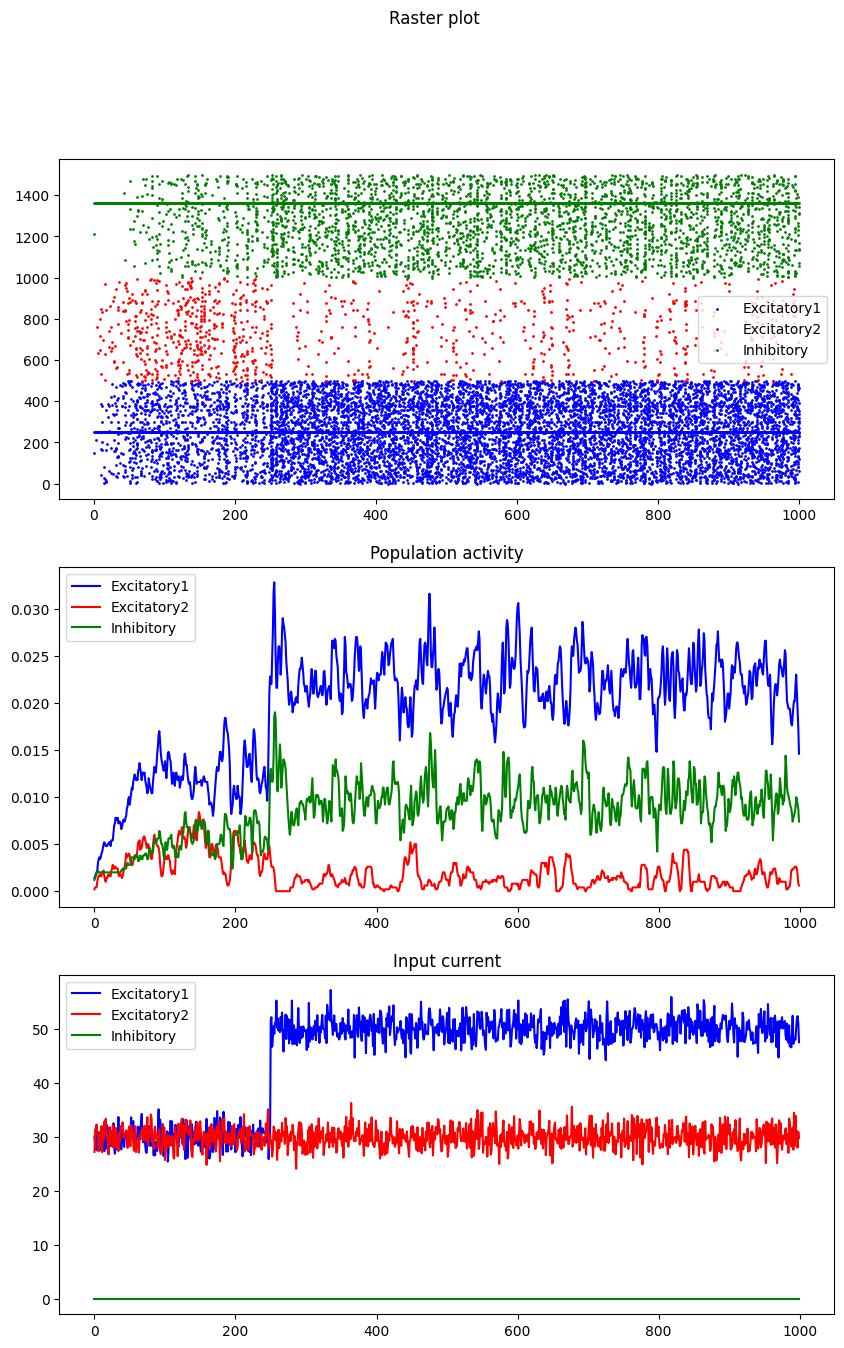

In [560]:
def B():
    I_constant_params = { 
        "F" : "constant",
        "init_current" : 50
    }; I_constant = Current(params = I_constant_params)
    I = I_constant

    Excitatory1_behavior = {
        2 : Current(params = { "F" : "noisy_step", "init_current" : 30, "mean" : 0, "std" : 2, "t0" : 25, "t1" : 110, "amplitude" : 20}),
        4 : Dendrite(),
        5 : lif,
        9 : Recorder(tag = "Excitatory1_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "Excitatory1_event", variables = ["SPIKE"])
    }

    Excitatory2_behavior = {
        2 : Current(params = { "F" : "noisy_step", "init_current" : 30, "mean" : 0, "std" : 2, "t0" : 25, "t1" : 110, "amplitude" : 0}),
        4 : Dendrite(),
        5 : lif,
        9 : Recorder(tag = "Excitatory2_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "Excitatory2_event", variables = ["SPIKE"])
    }

    Inhibitory_behavior = {
        2 : Current(params = { "F" : "constant", "init_current" : 0, "mean" : 0, "std" : 0.2}),
        4 : Dendrite(),
        5 : lif,
        9 : Recorder(tag = "Inhibitory_record", variables = ["U", "I", "A", "I_cpy"]),
        10: EventRecorder(tag = "Inhibitory_event", variables = ["SPIKE"])
    }


    network = Network(behavior={1: TimeResolution(dt = 0.1)}, dtype=torch.float64, device = "cpu", synapse_mode = "SxD")
    Excitatory1_population = NeuronGroup(size = 500, net = network, tag = "Excitatory1, Excitatory", behavior = Excitatory1_behavior)
    Excitatory2_population = NeuronGroup(size = 500, net = network, tag = "Excitatory2, Excitatory", behavior = Excitatory2_behavior)
    Inhibitory_population = NeuronGroup(size = 500, net = network, tag = "Inhibitory",               behavior = Inhibitory_behavior)

    synapseGroup_prams_EE = {
        "connectivity_mode" : "FCP",
        "transfer_mode" : "Dirac",
        "tau_syn" : 5,
        "g" : 20,
        "N" : 150,
        "p" : 0.7,
        "J0" : 1500,
        "isInhibitory" : 0,
    }
    synapseGroup_prams_EI = {
        "connectivity_mode" : "FULL",
        "transfer_mode" : "Dirac",
        "tau_syn" : 5,
        "g" : 20,
        "N" : 150,
        "p" : 0.9,
        "J0" : 1500,
        "isInhibitory" : 0,
    }
    synapseGroup_prams_IE = {
        "connectivity_mode" : "FULL",
        "transfer_mode" : "Dirac",
        "tau_syn" : 5,
        "g" : 20,
        "N" : 150,
        "p" : 0.9,
        "J0" : 1500,
        "isInhibitory" : 1,
    }
    synapse_G_E1E1 = SynapseGroup(net = network, src = Excitatory1_population, dst = Excitatory1_population, behavior = {3 : Transfer(params = synapseGroup_prams_EE)}, tag = "E1-E1")
    synapse_G_E2E2 = SynapseGroup(net = network, src = Excitatory2_population, dst = Excitatory2_population, behavior = {3 : Transfer(params = synapseGroup_prams_EE)}, tag = "E2-E2")
    synapse_G_E1I  = SynapseGroup(net = network, src = Excitatory1_population, dst = Inhibitory_population , behavior = {3 : Transfer(params = synapseGroup_prams_EI)}, tag = "E1-I")
    synapse_G_E2I  = SynapseGroup(net = network, src = Excitatory2_population, dst = Inhibitory_population , behavior = {3 : Transfer(params = synapseGroup_prams_EI)}, tag = "E2-I")
    synapse_G_IE1  = SynapseGroup(net = network, src = Inhibitory_population , dst = Excitatory1_population, behavior = {3 : Transfer(params = synapseGroup_prams_IE)}, tag = "I-E1")
    synapse_G_IE2  = SynapseGroup(net = network, src = Inhibitory_population , dst = Excitatory2_population, behavior = {3 : Transfer(params = synapseGroup_prams_IE)}, tag = "I-E2")

    network.initialize()
    network.simulate_iterations(1000)


    fig, axs = plt.subplots(3,1)
    fig.set_size_inches(10, 15)
    
    fig.suptitle("Raster plot")
    axs[0].scatter(network["Excitatory1_event", 0].variables["SPIKE"][:, 0], network["Excitatory1_event", 0].variables["SPIKE"][:, 1], s = 1, c = "b")
    axs[0].scatter(network["Excitatory2_event", 0].variables["SPIKE"][:, 0], network["Excitatory2_event", 0].variables["SPIKE"][:, 1] + Excitatory1_population.size, s = 1, c = "r")
    axs[0].scatter(network["Inhibitory_event", 0].variables["SPIKE"][:, 0], network["Inhibitory_event", 0].variables["SPIKE"][:, 1] + Excitatory1_population.size + Excitatory2_population.size, s = 1, c = "g")
    axs[0].legend(["Excitatory1", "Excitatory2", "Inhibitory"])
    
    axs[1].set_title("Population activity")
    act = network["Excitatory1_record", 0].variables["A"]
    act = np.convolve(act, np.ones(10)/10, mode = "same")
    axs[1].plot(act, c = "b")
    act = network["Excitatory2_record", 0].variables["A"]
    act = np.convolve(act, np.ones(10)/10, mode = "same")
    axs[1].plot(act, c = "r")
    act = network["Inhibitory_record", 0].variables["A"]
    act = np.convolve(act, np.ones(10)/10, mode = "same")
    axs[1].plot(act, c = "g")
    axs[1].legend(["Excitatory1", "Excitatory2", "Inhibitory"])

    axs[2].set_title("Input current")
    axs[2].plot(network["Excitatory1_record", 0].variables["I_cpy"][:, :1], c = "b")
    axs[2].plot(network["Excitatory2_record", 0].variables["I_cpy"][:, :1], c = "r")
    axs[2].plot(network["Inhibitory_record", 0].variables["I_cpy"][:, :1], c = "g")
    axs[2].legend(["Excitatory1", "Excitatory2", "Inhibitory"])
    


    plt.show()


B()